In [213]:
# Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid

random_state = 42

# 1) Load the dataset1.csv and explore the data, showing size, structure and histograms of numeric data; show the histogram of the frequencies of the class labels, contained in the “y” column.

The dataset has 1200 rows and 1200 columns


,0,1,y,2
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,0.507500,2.494236
std,0.804770,0.507227,0.500152,0.589235
min,0.343023,0.509424,0.000000,1.500260
25%,1.806657,1.809635,0.000000,1.974389
50%,2.744439,1.983524,1.000000,2.469778
75%,3.092275,2.201484,1.000000,2.995198
max,3.529782,3.647299,1.000000,3.498523


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

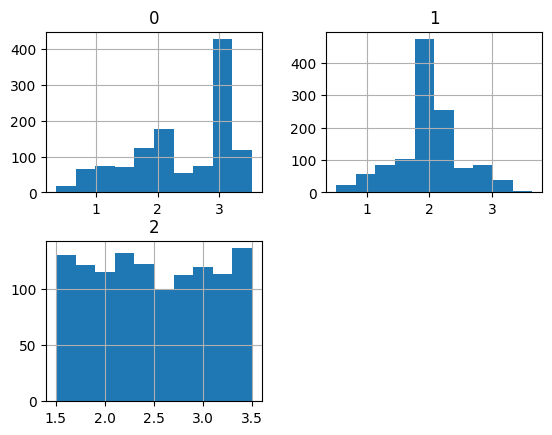

In [214]:
df = pd.read_csv('./exam_superv.csv')

print(f"The dataset has {df.shape[0]} rows and {df.shape[0]} columns")

display(df.describe())

df.drop('y', axis=1).hist()

Text(0.5, 0, 'y')

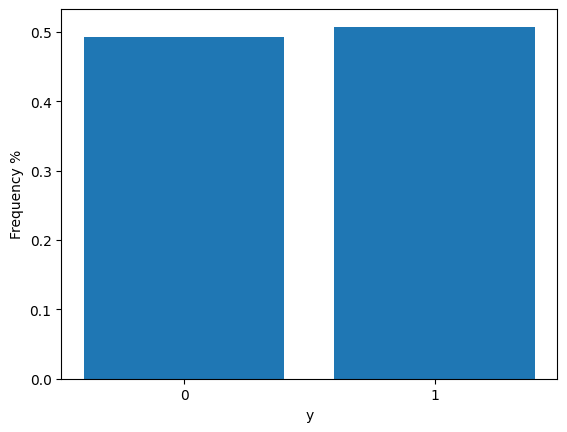

In [215]:
vals, n_occ = np.unique(df['y'], return_counts=True)
n_occ = n_occ / df.shape[0] # frequency

plt.bar(list(map(str, vals)), n_occ)
plt.ylabel('Frequency %')
plt.xlabel('y')


# 2) drop the column “y” and find the best clustering scheme and hyperparameters able to reproduce the y column (hint: before clustering you can consider dropping columns with little correlation to “y”; perhaps you should consider more than one estimator for clustering) 

In [216]:
list(df.columns[df.columns != 'y'])

['0', '1', '2']

In [217]:
# Drop the column with min correlation to y
col_to_drop = df.corr()['y'].abs().idxmin()
df.drop(columns=col_to_drop, inplace=True)
cols = list(df.columns[df.columns != 'y'])

<Axes: xlabel='0', ylabel='2'>

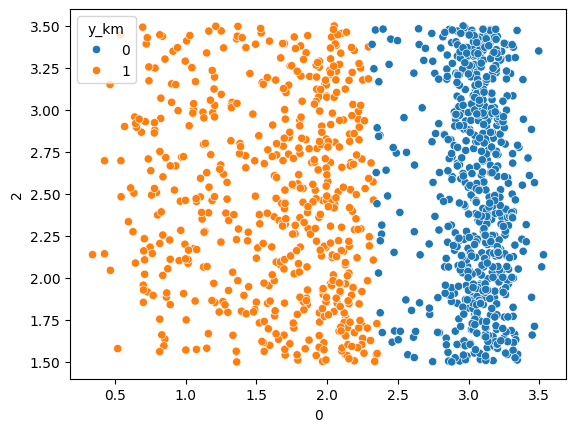

In [218]:
# Find data and label
X = df.drop('y', axis=1)
y = df['y']

# # Find the best clustering schema
# inertia_scores = []
# silhouette_scores = []
# k_range = range(2,11)
# for k in k_range :
#     km = KMeans(random_state=random_state, n_clusters=k)
#     y_km = km.fit_predict(X)
#     inertia_scores.append(km.inertia_)
#     silhouette_scores.append(silhouette_score(X, y_km))

# # Use elbow method to choose the best k
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('Number of clusters')
# ax1.set_ylabel('Inertia', color=color)
# ax1.tick_params('y', color=color)
# ax1.plot(k_range, inertia_scores, color=color)

# ax2 = ax1.twinx()

# color = 'tab:blue'
# ax2.set_ylabel('Silhouette', color=color)
# ax2.tick_params('y', color=color)
# ax2.set_ylim(0,1)
# ax2.plot(k_range, silhouette_scores, color=color)

######################################################################################################
######################################################################################################

# We need to reproduce 'y' so we already know that the number of clusters should be 2
y_km = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)
df['y_km'] = y_km
# sns.pairplot(df.drop('y', axis=1), hue='y_km') # Obtained
sns.scatterplot(x = cols[0],y = cols[1],data=df.drop(['y'], axis=1),hue = 'y_km')

# sns.pairplot(df.drop('y_km', axis=1), hue='y') # Golden standard
# sns.scatterplot(x = cols[0],y = cols[1],data=df.drop(['y_km'], axis=1),hue = 'y').plot()

In [219]:
# Now we try also DBSCAN

params = ParameterGrid([{
    'eps': list(np.arange(0.1, 1.0, 0.1)),
    'min_samples' : [*range(1,10)],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'] # --> mon cambia null
}])

columns = ["eps", "min_samples", "algorithm", "n_clusters", "silhouette", "unclust%"]
result = pd.DataFrame(columns=columns)

for i in range(len(params)) :
    # Use the model
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)

    # Handle noise
    n = len(np.unique(y_db[y_db != -1]))
    if n > 1 :
        X_cl = X.loc[y_db != -1, :]
        y_cl = y_db[y_db != -1]
        sil_score = silhouette_score(X_cl, y_cl)
        uncl_ratio = (1 - y_cl.shape[0]/y_db.shape[0]) * 100
        result.loc[len(result)] = [db.eps, db.min_samples, db.algorithm , n, sil_score, uncl_ratio]

# for i in range(len(params)):
#     db = DBSCAN(**(params[i]))
#     y_db = db.fit_predict(X)
#     cluster_labels_all = np.unique(y_db) # Considerando i singoli labels
#     cluster_labels = cluster_labels_all[cluster_labels_all != -1] # Che sono siano rumore
#     n_clusters = len(cluster_labels)
#     if 1 < n_clusters and n_clusters < len(y_db): # Se ci sono meno cluster (ma almeno 1) di prima
#         X_cl = X.loc[y_db!=-1,:] # seleziona tutte le colonne per le righe dove il label corrispondente non è rumore.
#         y_db_cl = y_db[y_db!=-1] # seleziona i labels non rumore
#         silhouette = silhouette_score(X_cl,y_db_cl)
#         uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100 # percentuale di punti che non appartengono a nessun cluster
#         result.loc[len(result)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]


In [220]:
# We inspect the results, focusing on silhouette and the % of unclustered
sorted_result = result.sort_values(by=['silhouette', 'unclust%'], ascending=[False, True]).reset_index()
sorted_result

,index,eps,min_samples,algorithm,n_clusters,silhouette,unclust%
0,9,0.2,1,auto,3,0.266226,0.000000
1,19,0.2,1,ball_tree,3,0.266226,0.000000
2,29,0.2,1,kd_tree,3,0.266226,0.000000
3,39,0.2,1,brute,3,0.266226,0.000000
4,7,0.1,8,auto,13,0.230777,26.083333
5,17,0.1,8,ball_tree,13,0.230777,26.083333
6,27,0.1,8,kd_tree,13,0.230777,26.083333
7,37,0.1,8,brute,13,0.230777,26.083333
8,8,0.1,9,auto,13,0.214354,28.500000
9,18,0.1,9,ball_tree,13,0.214354,28.500000


In [221]:
# We have to filter the results 
sorted_result = sorted_result[sorted_result['unclust%'] < 10]

In [222]:
best_parms = params[int(sorted_result.loc[0]['index'])] # the first of bests
best_parms

{'min_samples': 1, 'eps': 0.2, 'algorithm': 'auto'}

<Axes: xlabel='0', ylabel='2'>

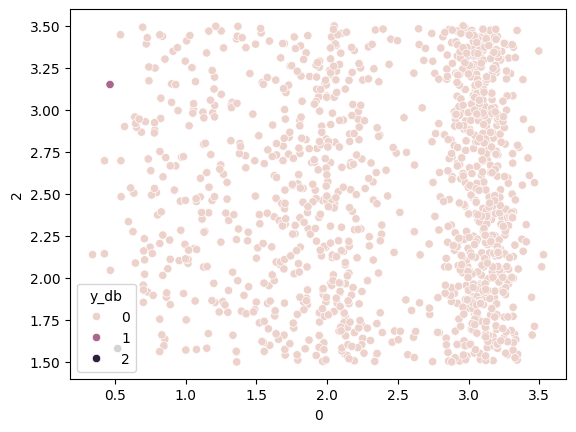

In [223]:
db = DBSCAN(**(best_parms))
y_db = db.fit_predict(X)
df['y_db'] = y_db
# sns.pairplot(df.drop(['y', 'y_km'], axis=1), hue='y_db') # Obtained
sns.scatterplot(x = cols[0],y = cols[1], data=df.drop(['y', 'y_km'], axis=1), hue='y_db')


We obtained very bad results so we will follow the KMeans clustering scheme

# 3) show the difference between the original “y” column and the labels generated by the clustering, it can be expressed as “accuracy”, produce also the confusion matrix.

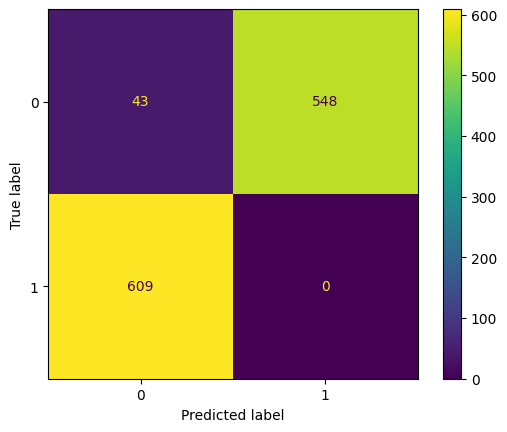

In [224]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y, y_km)).plot()

This happens because the '0' was seen as '1' and viceversa, but the clustering was good, we just need to switch the numbers

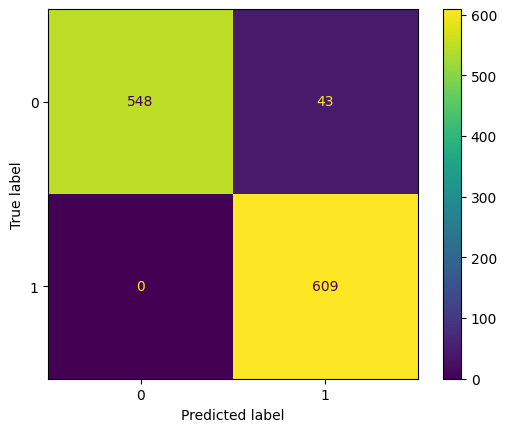

In [225]:
y_km = 1 -y_km # 0 <-> 1 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
ConfusionMatrixDisplay(confusion_matrix(y, y_km)).plot()

# 4) apply the same transformations, to dataset2.csv, then apply the best clustering scheme and hyper parameters and plot the data with the assigned labels

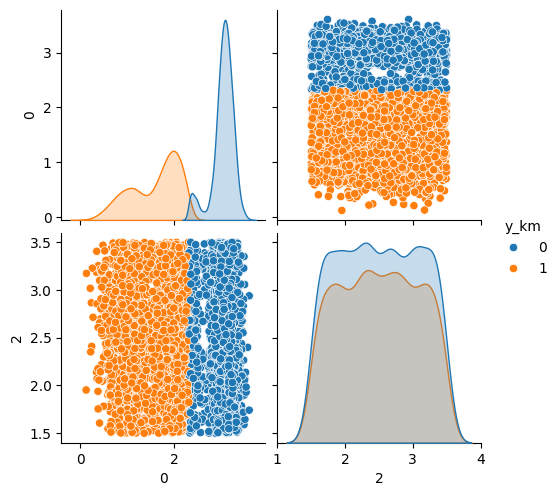

In [229]:
df = pd.read_csv('./exam_unsuperv.csv')
df.drop(columns=col_to_drop, inplace=True)

y_km = KMeans(n_clusters=2, random_state=random_state).fit_predict(df)
df['y_km'] = y_km
cols = list(df.columns[df.columns != 'y_km'])

sns.scatterplot(x = cols[0],y = cols[1],data=df,hue = 'y_km')
# sns.pairplot(df, hue='y_km')